In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Full imports
import torch
from blockgen.configs import VoxelConfig, DiffusionConfig
from blockgen.utils import create_model_and_trainer, create_dataloaders
from blockgen.inference import DiffusionInference3D
from scripts.generate import load_model_for_inference

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [5]:
# Configs
voxel_config = VoxelConfig(
    use_rgb=True,
    default_color=[0.5, 0.5, 0.5],
    alpha_weight=1.0,
    rgb_weight=1.0
)

diffusion_config = DiffusionConfig(
    num_timesteps=1000,
    use_ema=True,
    ema_decay=0.9999,
    ema_update_after_step=0,
    ema_device=device,
    seed=42
)

In [ ]:
# Create model and trainer
trainer, model = create_model_and_trainer(
    voxel_config=voxel_config,
    diffusion_config=diffusion_config,
    resolution=32,
    device=device
)

In [ ]:
train_loader, test_loader = create_dataloaders(
    voxel_dir="objaverse_data_voxelized",
    annotation_file="objaverse_data/annotations.json",
    config=diffusion_config,
    config_voxel=voxel_config,
    batch_size=4
)

In [ ]:
metrics = trainer.train(
    train_loader,
    test_loader,
    total_steps=60_000,
    save_every=5_000,
    eval_every=10_000,
    save_dir='runs/experiment_color_60k',
    checkpoint_path='/scratch/students/2024-fall-sp-pabdel/3D-BlockGen/runs/experiment_color_60k/checkpoints/checkpoint_step_50000.pth'
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['training_losses'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(metrics['test_steps'], metrics['test_losses'])
plt.title('Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [6]:
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install iopath
!pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#print(f"pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html")

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu117_pyt201/download.html


In [13]:
model = load_model_for_inference('runs/experiment_color_60k/models/model_step_50000', voxel_config=voxel_config, diffusion_config=diffusion_config, device=device, ema=True)

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 50000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Loaded EMA model weights


In [14]:
# Inference
inferencer = DiffusionInference3D(
    model=model,
    noise_scheduler=model.noise_scheduler,
    config=voxel_config,
    device=device
)

In [ ]:
samples = inferencer.sample(
    prompt="A Gun",
    num_samples=2,
    image_size=(32, 32, 32),
    show_intermediate=False,
    guidance_scale=2,
    use_mean_init=False,
    py3d=False
)

Sampling Steps:  44%|██████████████████████████▊                                  | 440/1000 [01:59<02:31,  3.69it/s]

In [ ]:
inferencer.visualize_samples(samples, threshold=0.5)

Number of vertices: 21944
Max face index: 21943
Number of faces: 32916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


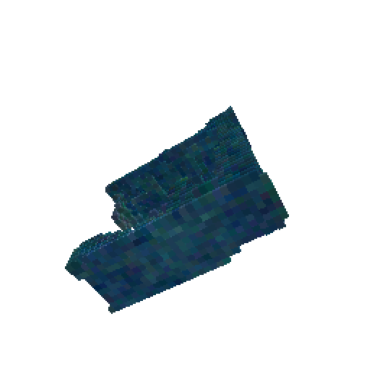

TypeError: save_ply() got an unexpected keyword argument 'verts_colors'

In [17]:
inferencer.visualize_samples_p3d(samples[1], threshold=0.5)